In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import seaborn as sns
import cv2
import os
import warnings
import albumentations as aug
import seaborn as sns
from shutil import copyfile
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from PIL import Image
from IPython.display import FileLink
from torchvision.transforms import transforms as T
from torchvision import models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix

warnings.filterwarnings('ignore')

In [3]:
copyfile(src = "../input/pneumonia-detector-utils/constants.py", dst = "../working/constants.py")
copyfile(src = "../input/pneumonia-detector-utils/pneumonia_model.py", dst = "../working/pneumonia_model.py")
copyfile(src = "../input/pneumonia-detector-utils/utils.py", dst = "../working/utils.py")

'../working/utils.py'

In [4]:
from constants import *
from utils import RandomPerspectiveAug, RandomRotation_FlipAug, RandomColorJitterAug, detach_from_gpu, device
from pneumonia_model import pneumonia_detector

In [5]:
labels = labels
IMG_SIZE = IMG_SIZE
def get_data(directory):
    data = []
    for label in labels:
        path = os.path.join(directory, label)
        class_type = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.resize(cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
                data.append([img_arr, class_type])
            except Exception as e:
                print(e)
    return np.array(data)       

In [6]:
train_data = get_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
test_data = get_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')
validation_data = get_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/val')

OpenCV(4.5.4) /tmp/pip-req-build-jpmv6t9_/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.4) /tmp/pip-req-build-jpmv6t9_/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.4) /tmp/pip-req-build-jpmv6t9_/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.4) /tmp/pip-req-build-jpmv6t9_/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [7]:
x_train = np.array([example for example, label in train_data]) / 255.
y_train = np.array([label for example, label in train_data])

x_val = np.array([example for example, label in validation_data]) / 255.
y_val = np.array([label for example, label in validation_data])

x_test = np.array([example for example, label in test_data]) / 255.
y_test = np.array([label for example, label in test_data])

<AxesSubplot:title={'center':'0: Pneumonia 1: Normal'}, ylabel='count'>

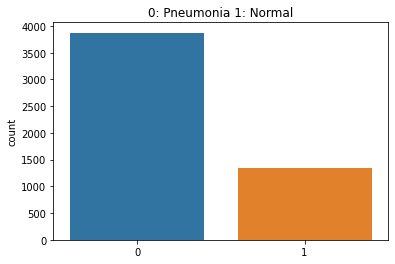

In [8]:
plt.title('0: Pneumonia 1: Normal')
sns.countplot(y_train)

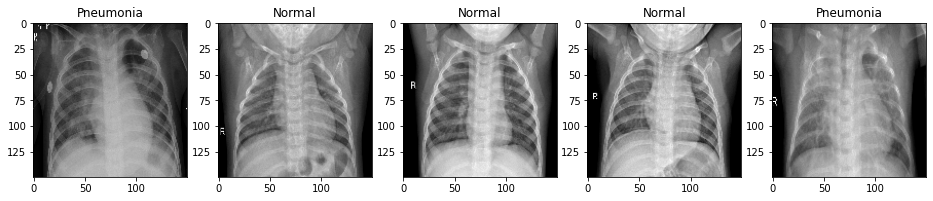

In [9]:
# Visualizing 5 random examples from training data

fig, axs = plt.subplots(1, 5, figsize = (16, 10))

for i in range(5):
    index = np.random.randint(0, len(x_train))
    axs[i].imshow(x_train[index].reshape(IMG_SIZE, IMG_SIZE), cmap = 'gray')
    label = 'Pneumonia' if y_train[index] == 0 else 'Normal'
    axs[i].set_title(label)

In [10]:
x_train = x_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1) # (No. of Examples, Image Width, Image Height, No. of Color Channels)
x_val = x_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
x_test = x_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

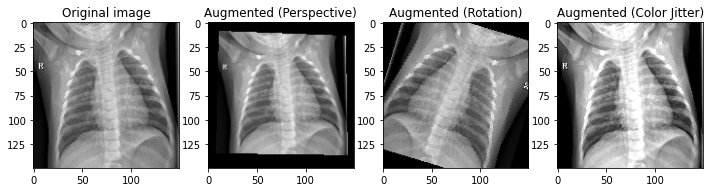

In [11]:
# Data Augmentation by Random Perpective to increase training data
# Grab random 1000 images of non-pneumonial x-rays

normal_examples_idx = [idx for idx, label in enumerate(y_train) if label == 1]

# Sample augmentation

sample_image = x_train[np.random.choice(normal_examples_idx)]
sample_perspective_aug = RandomPerspectiveAug(sample_image)
sample_rotation_aug = RandomRotation_FlipAug(sample_image)
sample_jitter_aug = RandomColorJitterAug(sample_image)

fig, axs = plt.subplots(1, 4, figsize = (12, 10))
axs[0].imshow(sample_image.reshape(IMG_SIZE, IMG_SIZE), cmap = 'gray')
axs[0].set_title('Original image')

axs[1].imshow(sample_perspective_aug.reshape(IMG_SIZE, IMG_SIZE), cmap = 'gray')
axs[1].set_title('Augmented (Perspective)')

axs[2].imshow(sample_rotation_aug.reshape(IMG_SIZE, IMG_SIZE), cmap = 'gray')
axs[2].set_title('Augmented (Rotation)')

axs[3].imshow(sample_jitter_aug.reshape(IMG_SIZE, IMG_SIZE), cmap = 'gray')
axs[3].set_title('Augmented (Color Jitter)')
plt.show()

# Apply both augmentations to 1000 samples

perspective_aug_images = [RandomPerspectiveAug(image) for image in x_train[np.random.choice(normal_examples_idx, size = n_augmentations)]]
rotation_aug_images = [RandomRotation_FlipAug(image) for image in x_train[np.random.choice(normal_examples_idx, size = n_augmentations)]]
jitter_aug_images = [RandomColorJitterAug(image) for image in x_train[np.random.choice(normal_examples_idx, size = n_augmentations)]]

In [12]:
perspective_aug_images = torch.cat(perspective_aug_images, dim = 0)
rotation_aug_images = torch.cat(rotation_aug_images, dim = 0)
jitter_aug_images = torch.cat(jitter_aug_images, dim = 0)

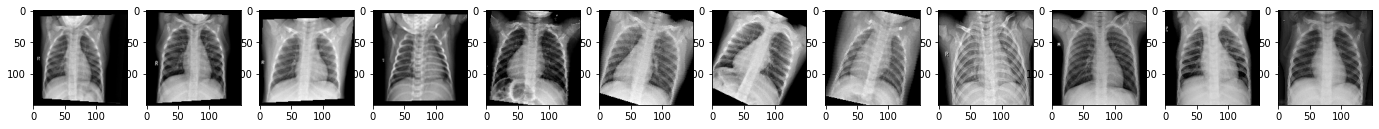

In [13]:
#Augmented Images

fig, axs = plt.subplots(1, 12, figsize = (24, 12))

for i in range(4):
    index = np.random.randint(0, len(perspective_aug_images))
    axs[i].imshow(perspective_aug_images[index].reshape(IMG_SIZE, IMG_SIZE), cmap = 'gray')

for i in range(4):
    index = np.random.randint(0, len(rotation_aug_images))
    axs[4 + i].imshow(rotation_aug_images[index].reshape(IMG_SIZE, IMG_SIZE), cmap = 'gray')

for i in range(4):
    index = np.random.randint(0, len(jitter_aug_images))
    axs[8 + i].imshow(jitter_aug_images[index].reshape(IMG_SIZE, IMG_SIZE), cmap = 'gray')

In [14]:
x_train = torch.tensor(x_train)
y_train = torch.tensor(y_train)

x_val = torch.tensor(x_val)
y_val = torch.tensor(y_val)

x_test = torch.tensor(x_test)
y_test = torch.tensor(y_test)

In [15]:
# Append the augmentations to the training set

x_train = torch.cat((x_train.squeeze(3), perspective_aug_images / 255., rotation_aug_images / 255., jitter_aug_images / 255.)).unsqueeze(3)
y_train = torch.cat((y_train, torch.ones(len(perspective_aug_images) + len(perspective_aug_images) + + len(jitter_aug_images))))

In [16]:
x_train = np.array(x_train).repeat(IN_CHANNELS, axis = -1)
x_val = np.array(x_val).repeat(IN_CHANNELS, axis = -1)
x_test = np.array(x_test).repeat(IN_CHANNELS, axis = -1)

x_train = torch.tensor(x_train).view(-1, IN_CHANNELS, IMG_SIZE, IMG_SIZE)
x_val = torch.tensor(x_val).view(-1, IN_CHANNELS, IMG_SIZE, IMG_SIZE)
x_test = torch.tensor(x_test).view(-1, IN_CHANNELS, IMG_SIZE, IMG_SIZE)

In [17]:
train_set = [example for example in zip(x_train, y_train)]
val_set = [example for example in zip(x_val, y_val)]
test_set = [example for example in zip(x_test, y_test)]

In [18]:
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_set, batch_size = test_batch_size, shuffle = True)

In [19]:
model = pneumonia_detector()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer = optimizer, gamma = gamma)

loss_func = nn.BCEWithLogitsLoss()

loss_vals = []
accuracy_vals = [0]

for epoch in range(1, epochs + 1):

    model.train()
    
    loss_val = 0
    correct = 0
    count = 0
    
    scheduler.step()

    for batch in tqdm(train_loader, desc = 'Epoch {}'.format(epoch), ncols = 100, colour = 'blue'):
        
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        labels = labels.unsqueeze(dim = 1)
        prediction = model(images.float())
        
        loss = loss_func(prediction, labels.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_val += loss.item()
        count += len(labels)
        correct += sum((prediction.sigmoid() > 0.5).int().eq(labels))
        accuracy = correct / count
    
        loss_vals.append(loss_val)
        accuracy_vals.append(detach_from_gpu(accuracy))
        
    print('Training Loss: {} Accuracy: {}'.format(round(loss_val, 2), round(detach_from_gpu(accuracy).item(), 3)))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 1: 100%|████████████████████████████████████████████████████| 119/119 [00:19<00:00,  6.25it/s]


Training Loss: 19.88 Accuracy: 0.952


Epoch 2: 100%|████████████████████████████████████████████████████| 119/119 [00:12<00:00,  9.50it/s]


Training Loss: 4.29 Accuracy: 0.989


Epoch 3: 100%|████████████████████████████████████████████████████| 119/119 [00:12<00:00,  9.43it/s]


Training Loss: 2.77 Accuracy: 0.993


Epoch 4: 100%|████████████████████████████████████████████████████| 119/119 [00:12<00:00,  9.53it/s]


Training Loss: 2.67 Accuracy: 0.994


Epoch 5: 100%|████████████████████████████████████████████████████| 119/119 [00:12<00:00,  9.46it/s]

Training Loss: 2.72 Accuracy: 0.994


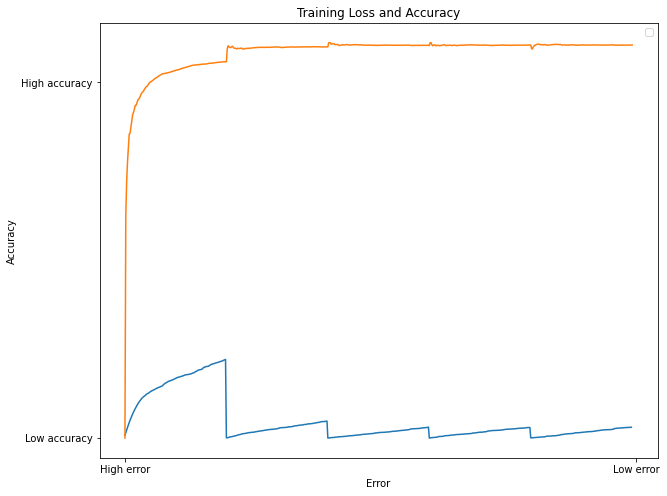

In [20]:
plt.figure(figsize=(10, 8))
plt.title('Training Loss and Accuracy')
plt.xticks([0.5, 600], ['High error', 'Low error'])
plt.yticks([0, 90], ['Low accuracy', 'High accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Error')
plt.plot(loss_vals)
plt.plot([val * 100 for val in accuracy_vals])
plt.legend()
plt.show()

In [21]:
val_preds = (model(x_val.cuda().float()).sigmoid() > 0.5).int()
print('Validation Accuracy: {}'.format(round(accuracy_score(y_val, detach_from_gpu(val_preds).reshape(-1)), 2)))

print('-----------------------------------')

test_preds = (model(x_test.cuda().float()).sigmoid() > 0.5).int()
print('Test Accuracy: {}'.format(round(accuracy_score(y_test, detach_from_gpu(test_preds).reshape(-1)),2)))

Validation Accuracy: 0.88
-----------------------------------
Test Accuracy: 0.86


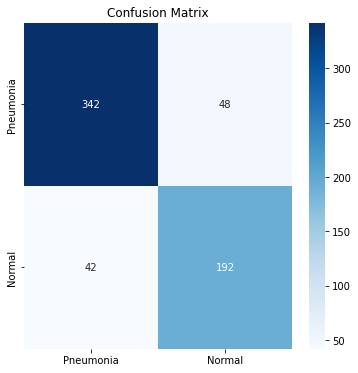

In [22]:
cm = confusion_matrix(y_test, detach_from_gpu(test_preds).reshape(-1))
plt.figure(figsize = (6, 6))
plt.title('Confusion Matrix')
sns.heatmap(cm, cmap = 'Blues', annot = True, xticklabels = ['Pneumonia', 'Normal'], yticklabels = ['Pneumonia', 'Normal'], fmt = 'd')
plt.show()

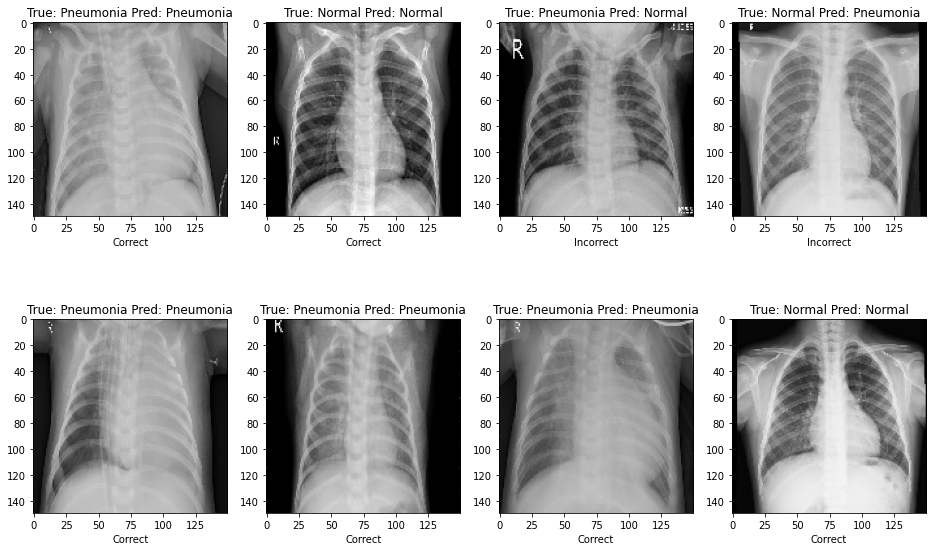

In [23]:
images, labels = next(iter(test_loader))
prediction = detach_from_gpu((model(images.float().to(device)).sigmoid() > 0.5).int()).reshape(-1)        
fig, axs = plt.subplots(2, 4, figsize = (16, 10))

for i in range(2):
    for j in range(4):
        axs[i][j].imshow(images[j + (i * 4)].view(IMG_SIZE, IMG_SIZE, 3))
        prediction_hyp = 'Pneumonia' if prediction[j + (i * 4)] == 0 else 'Normal'
        label = 'Pneumonia' if labels[j + (i * 4)] == 0 else 'Normal'
        title = 'True: ' + label + ' Pred: ' + str(prediction_hyp)
        axs[i][j].set_title(title)
        correct = 'Correct' if label == str(prediction_hyp) else 'Incorrect'
        axs[i][j].set_xlabel(correct)

In [24]:
# Save model
torch.save(model, 'pneumonia_detector_model.h5')

In [25]:
print('Download model weights')
FileLink('pneumonia_detector_model.h5')

Download model weights


/kaggle/working/pneumonia_detector_model.h5